In [44]:
import os
import numpy as np

In [45]:
class Data():
    def __init__(self, fname, ratio) -> None:
        f = open(fname)
        data = f.read()
        f.close

        # csv file split
        lines = data.split('\n')
        header = lines[0].split('.')
        lines = lines[1:]
        values = [line.split(',')[1:] for line in lines]
        self.float_data = np.array(values).astype('float32')
        self.data_length = self.float_data.shape[-1]

        # basic information
        self.ratio = ratio
        self.train_set_length = int(self.float_data.shape[0] * ratio[0])
        self.val_set_length = int(self.float_data.shape[0] * ratio[1])

        # data normalization
        Data.normalize(self)
    
    def normalize(self):
        import copy
        self.data = copy.deepcopy(self.float_data)
        mean = self.data[:self.train_set_length].mean(axis=0)
        self.data -= mean
        std = self.data[:self.train_set_length].std(axis=0)
        self.data /= std
        self.mean = mean
        self.std = std

    def get_generators(self, lookback, delay, batch_size=128, step=6):
        self.train_gen = Data.generator(self, lookback=lookback, delay=delay,
                                        min_index=0, max_index=self.train_set_length,
                                        shuffle=True, step=step, batch_size=batch_size)
        self.val_gen = Data.generator(self, lookback=lookback, delay=delay,
                                        min_index=self.train_set_length, max_index=self.train_set_length+self.val_set_length,
                                        shuffle=False, step=step, batch_size=batch_size)
        self.test_gen = Data.generator(self, lookback=lookback, delay=delay,
                                        min_index=self.train_set_length+self.val_set_length, max_index=None,
                                        shuffle=False, step=step, batch_size=batch_size)
        self.train_steps = (self.train_set_length - lookback) // batch_size
        self.val_steps = (self.val_set_length - lookback) // batch_size
        self.test_steps = ((len(self.data) - self.val_set_length - self.train_set_length - lookback)) // batch_size
        self.lookback = lookback
        self.batch_size = batch_size
        self.step = step

    def generator(self, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
        if max_index is None:
            max_index = len(self.data) - delay - 1
        i = min_index + lookback
        while True:
            if shuffle:
                rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            else:
                if i + batch_size >= max_index:
                    i = min_index + lookback
                rows = np.arange(i, min(i+batch_size, max_index))
                i += len(rows)
            samples = np.zeros((len(rows), lookback//step, self.data_length))
            targets = np.zeros((len(rows),))
            for j, row in enumerate(rows):
                indices = range(rows[j] - lookback, rows[j], step)
                samples[j] = self.data[indices]
                targets[j] = self.data[rows[j]+delay-1][1]
            yield samples, targets

def main(type:str, ratio=[0.5, 0.25, 0.25], lookback=2880, step=6, delay=144, batch_size=128, epochs=40):
    fname = './datasets/jena_climate/jena_climate_2009_2016.csv'
    dataset = Data(fname, ratio)
    dataset.get_generators(lookback=lookback, delay=delay, batch_size=batch_size, step=6)

    from tensorflow.keras import layers, models
    model = models.Sequential()
    history = None
    # simple ANN
    if type == 'ANN':
        model.add(layers.Flatten(input_shape=(lookback//step, dataset.data.shape[-1])))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1))
        model.compile(optimizer='RMSprop', loss='mae')
        history = model.fit_generator(dataset.train_gen, steps_per_epoch=dataset.train_steps, epochs=epochs,
                                    validation_data=dataset.val_gen, validation_steps=dataset.val_steps)

    # simple RNN
    if type == 'RNN':
        model.add(layers.SimpleRNN(32, activation='relu'))
        model.add(layers.Dense(1))
        model.compile(optimizer='RMSprop', loss='mae')
        history = model.fit_generator(dataset.train_gen, steps_per_epoch=500, epochs=epochs,
                                    validation_data=dataset.val_gen, validation_steps=dataset.val_steps)
        
    # simple LSTM
    if type == 'LSTM':
        model.add(layers.LSTM(32))
        model.add(layers.Dense(1))
        model.compile(optimizer='RMSprop', loss='mae')
        history = model.fit_generator(dataset.train_gen, steps_per_epoch=500, epochs=epochs,
                                    validation_data=dataset.val_gen, validation_steps=dataset.val_steps)
    model.summary()

    train_loss = model.evaluate_generator(dataset.train_gen, steps=dataset.val_steps)
    test_loss = model.evaluate_generator(dataset.test_gen, steps=dataset.test_steps)
    print('train_loss: ', train_loss)
    print('test_loss: ', test_loss)


    train_predictions = model.predict_generator(dataset.train_gen, steps=dataset.train_steps)
    test_predictions = model.predict_generator(dataset.test_gen, steps=dataset.test_steps)
    train_predictions = np.concatenate(train_predictions)
    test_predictions = np.concatenate(test_predictions)
    train_true_labels = []
    test_true_labels = []
    for _, targets in dataset.train_gen:
        train_true_labels.append(targets)
        if len(train_true_labels) * dataset.batch_size >= dataset.train_set_length:
            break

    for _, targets in dataset.test_gen:
        test_true_labels.append(targets)
        if len(test_true_labels) * dataset.batch_size >= len(dataset.data) - dataset.train_set_length - dataset.val_set_length:
            break

    train_true_labels = np.concatenate(train_true_labels)[:len(train_predictions)]
    test_true_labels = np.concatenate(test_true_labels)[:len(test_predictions)]

    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

    train_mae = mean_absolute_error(train_true_labels, train_predictions)
    test_mae = mean_absolute_error(test_true_labels, test_predictions)

    train_mape = mean_absolute_percentage_error(train_true_labels, train_predictions)
    test_mape = mean_absolute_percentage_error(test_true_labels, test_predictions)

    print('Train MAE:', train_mae)
    print('Test MAE:', test_mae)

    print('Train MAPE:', train_mape)
    print('Test MAPE:', test_mape)

    return model, history


In [46]:
def plotting(model, history, epochs):
    import matplotlib.pyplot as plt
    plt.plot(range(0, epochs), history.history['loss'], 'b')
    plt.plot(range(0, epochs), history.history['val_loss'], 'g')
    plt.legend(('train_loss', 'val_loss'))
    plt.show()

Epoch 1/40


/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:84: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset.train_gen, steps_per_epoch=dataset.train_steps, epochs=epochs,
2023-05-28 18:21:39.258113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1620/1620 [==============================] - ETA: 0s - loss: 0.8973

2023-05-28 18:21:51.266412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1620/1620 [==============================] - 17s 10ms/step - loss: 0.8973 - val_loss: 0.3964
Epoch 2/40
1620/1620 [==============================] - 17s 10ms/step - loss: 0.2485 - val_loss: 0.3551
Epoch 3/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.2211 - val_loss: 0.3548
Epoch 4/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.2058 - val_loss: 0.4147
Epoch 5/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.1962 - val_loss: 0.3682
Epoch 6/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.1901 - val_loss: 0.3627
Epoch 7/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.1856 - val_loss: 0.3961
Epoch 8/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.1813 - val_loss: 0.3695
Epoch 9/40
1620/1620 [==============================] - 16s 10ms/step - loss: 0.1789 - val_loss: 0.3848
Epoch 10/40
1620/1620 [==============================] - 16s 10ms/step - lo

/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:104: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss = model.evaluate_generator(dataset.train_gen, steps=dataset.val_steps)
/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:105: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss = model.evaluate_generator(dataset.test_gen, steps=dataset.test_steps)


train_loss:  0.1457975208759308
test_loss:  1.9002597332000732


/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:110: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_predictions = model.predict_generator(dataset.train_gen, steps=dataset.train_steps)
2023-05-28 18:32:20.378472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:111: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(dataset.test_gen, steps=dataset.test_steps)


Train MAE: 1.1759930518893058
Test MAE: 2.0632403384029945
Train MAPE: 6.020941887928432
Test MAPE: 5.552495169053295


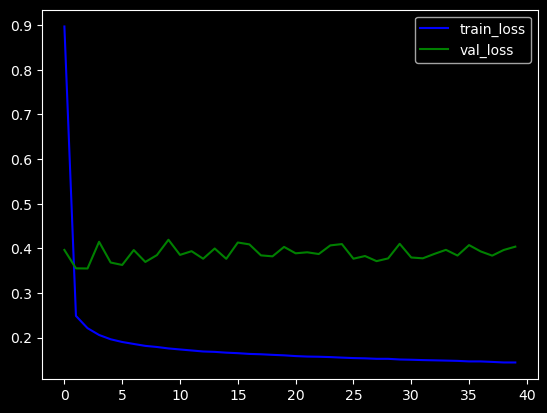

In [47]:
model_ann, history_ann = main('ANN')
plotting(model_ann, history_ann, 40)

/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:100: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset.train_gen, steps_per_epoch=500, epochs=epochs,


Epoch 1/40


2023-05-28 18:32:50.361759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 18:32:50.530865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 18:32:51.888034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.3066

2023-05-28 18:34:05.627077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 18:34:05.682059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 145s 277ms/step - loss: 0.3066 - val_loss: 0.2825
Epoch 2/40
500/500 [==============================] - 137s 275ms/step - loss: 0.2867 - val_loss: 0.2691
Epoch 3/40
500/500 [==============================] - 138s 277ms/step - loss: 0.2764 - val_loss: 0.2694
Epoch 4/40
500/500 [==============================] - 133s 267ms/step - loss: 0.2716 - val_loss: 0.2766
Epoch 5/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2636 - val_loss: 0.2768
Epoch 6/40
500/500 [==============================] - 139s 279ms/step - loss: 0.2573 - val_loss: 0.2786
Epoch 7/40
500/500 [==============================] - 137s 275ms/step - loss: 0.2525 - val_loss: 0.2795
Epoch 8/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2463 - val_loss: 0.2750
Epoch 9/40
500/500 [==============================] - 138s 277ms/step - loss: 0.2436 - val_loss: 0.2839
Epoch 10/40
500/500 [==============================] - 137s 274ms/step - lo

/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:104: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss = model.evaluate_generator(dataset.train_gen, steps=dataset.val_steps)
/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:105: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss = model.evaluate_generator(dataset.test_gen, steps=dataset.test_steps)


train_loss:  0.1757931262254715
test_loss:  0.33685439825057983


/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:110: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_predictions = model.predict_generator(dataset.train_gen, steps=dataset.train_steps)
2023-05-28 20:05:55.342592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 20:05:55.414428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/v9/bwnxmmgs13zd3yg44zhmyl5r0000gn/T/ipykernel_96967/4241187224.py:111: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(dataset.test_gen, steps=dataset.test_steps)


Train MAE: 1.1009194748509297
Test MAE: 0.5149458372005856
Train MAPE: 5.322432715480808
Test MAPE: 3.0655994488239453


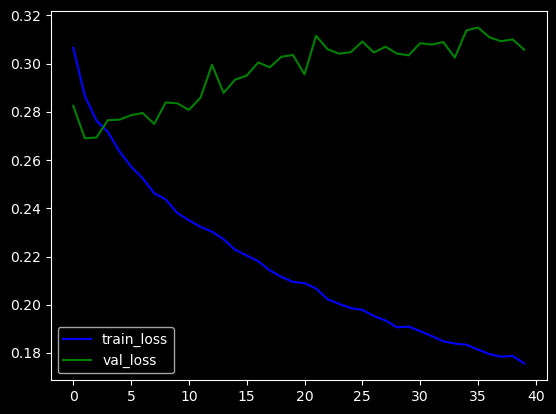

In [48]:
model_lstm, history_lstm = main('LSTM')
plotting(model_lstm, history_lstm, 40)